## Time series using ARIMA: exercise
Use the tractor sales dataset to predict future sales:
- check the stationarity of the time series
- guess using visual techniques the optimal ARIMA parameters
- determine the optimal ARIMA parameters and the error
- pay attention to the train - validation - test split proportions

In [31]:
import pandas as pd
import numpy as np
# matplotlib is the Python library for drawing diagrams
import matplotlib.pyplot as plt
%matplotlib inline
# set the size of the diagrams
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15,5

In [32]:
# import and explore the data
url = 'https://raw.githubusercontent.com/HOGENT-Databases/BI-BigData/master/data/Tractor-Sales.csv'
data = pd.read_csv(url)
print(data.head(100))
print('\n Data Types:')
print(data.dtypes)
print(data.count())

   Month-Year  Number of Tractors Sold
0      Jan-03                      141
1      Feb-03                      157
2      Mar-03                      185
3      Apr-03                      199
4      May-03                      203
..        ...                      ...
95     Dec-10                      428
96     Jan-11                      397
97     Feb-11                      400
98     Mar-11                      498
99     Apr-11                      536

[100 rows x 2 columns]

 Data Types:
Month-Year                 object
Number of Tractors Sold     int64
dtype: object
Month-Year                 144
Number of Tractors Sold    144
dtype: int64


In [33]:
# convert the month-string to a date and use that date as an index
parser = lambda x: pd.datetime.strptime(x,'%b-%y')
ts = pd.read_csv(url, parse_dates=['Month-Year'], index_col='Month-Year',date_parser=parser)
print(ts.head())


            Number of Tractors Sold
Month-Year                         
2003-01-01                      141
2003-02-01                      157
2003-03-01                      185
2003-04-01                      199
2003-05-01                      203


In [34]:
ts.index

DatetimeIndex(['2003-01-01', '2003-02-01', '2003-03-01', '2003-04-01',
               '2003-05-01', '2003-06-01', '2003-07-01', '2003-08-01',
               '2003-09-01', '2003-10-01',
               ...
               '2014-03-01', '2014-04-01', '2014-05-01', '2014-06-01',
               '2014-07-01', '2014-08-01', '2014-09-01', '2014-10-01',
               '2014-11-01', '2014-12-01'],
              dtype='datetime64[ns]', name='Month-Year', length=144, freq=None)

The index is now of type "datetime64", which is necessary to handle it as a time series

### Stationarity
To model a time series, it must be stationary. Stationary means that the distribution of the data doesn't change with time. For a time series to be stationary it must fulfill three criteria. These are: 
* The series has zero trend, it isn't growing or shrinking.
* The variance is constant. The average distance of the data points from the zero line isn't changing.
* The autocorrelation is constant. How each value in the time series is related to its neighbors stays the same. 

We will further explore these three concepts. 

But why is stationarity important? Most of the TS models work on the assumption that the TS is stationary. Intuitively, we can say that if a TS has a particular behaviour over time, there is a very high probability that it will follow the same behaviour in the future. Also, the theories related to stationary series are more mature and easier to implement as compared to non-stationary series.

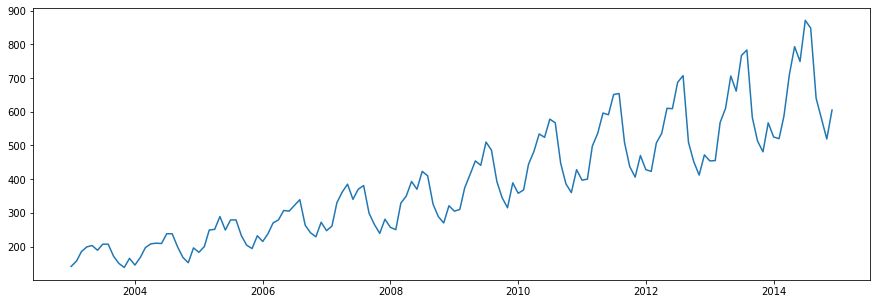

In [35]:
# test stationarity
# The data can be plotted inline using the following command from the mathplotlib library
plt.plot(ts)

It is clearly evident that there is an **overall increasing trend** in the data along with some **seasonal variations**. However, it might not always be possible to make such visual inferences. So, more formally, we can check stationarity by plotting Rolling Statistics: we can plot the moving average or moving variance and see if it varies with time. By moving average/variance we mean that at any instant ‘t’, we’ll take e.g. the average/variance of the last year, i.e. last 12 months. Clearly, this is more of a visual technique.

### Moving average and moving variance

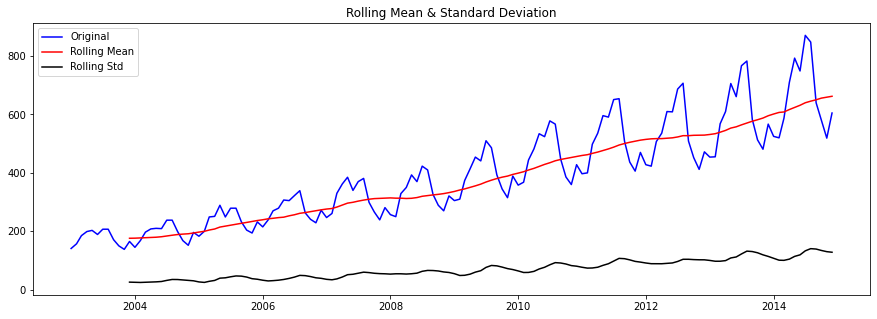

In [36]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
test_stationarity(ts)

Though the variation in standard deviation is small, the mean is clearly increasing with time so
**this is not a stationary series**. 

Now **let's subtract the moving average from the original series**. Note that since we are taking the average of the last 12 values, rolling mean is not defined for the first 11 values. This can be observed as:

In [37]:
moving_avg = ts.rolling(12).mean()
ts_moving_avg_diff = ts - moving_avg
ts_moving_avg_diff.head(12)

,Number of Tractors Sold
Month-Year,
2003-01-01,NaN
2003-02-01,NaN
2003-03-01,NaN
2003-04-01,NaN
2003-05-01,NaN
2003-06-01,NaN
2003-07-01,NaN
2003-08-01,NaN
2003-09-01,NaN


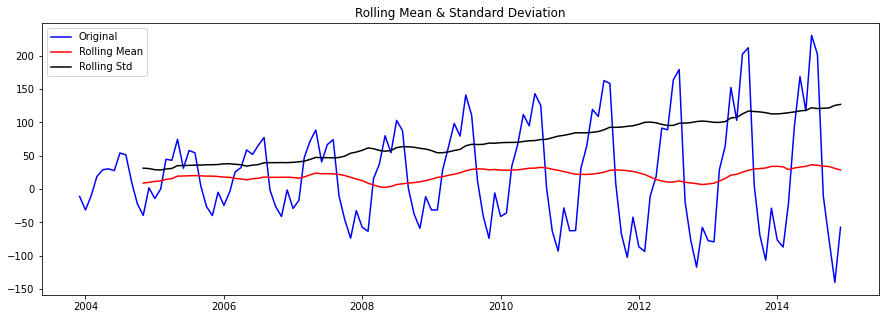

In [38]:
# Lets drop these NaN values and check the plots to test stationarity by 
# using the function "test_stationarity" we defined earlier
ts_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_moving_avg_diff)

This looks like a much better series. The rolling values appear to be varying only slightly. 
Conclusion: **subtracting the moving average is a way to make the time series data (more) stationary**. 

### Differencing
One of the most common methods of dealing with both trend and seasonality is differencing. In this technique, we take the difference of the observation at a particular instant with that at the previous instant. This mostly works well in improving stationarity. First order differencing can be done in Pandas as:

            Number of Tractors Sold
Month-Year                         
2003-01-01                      141
2003-02-01                      157
2003-03-01                      185
2003-04-01                      199
2003-05-01                      203

            Number of Tractors Sold
Month-Year                         
2003-01-01                      NaN
2003-02-01                    141.0
2003-03-01                    157.0
2003-04-01                    185.0
2003-05-01                    199.0

            Number of Tractors Sold
Month-Year                         
2003-01-01                      NaN
2003-02-01                     16.0
2003-03-01                     28.0
2003-04-01                     14.0
2003-05-01                      4.0


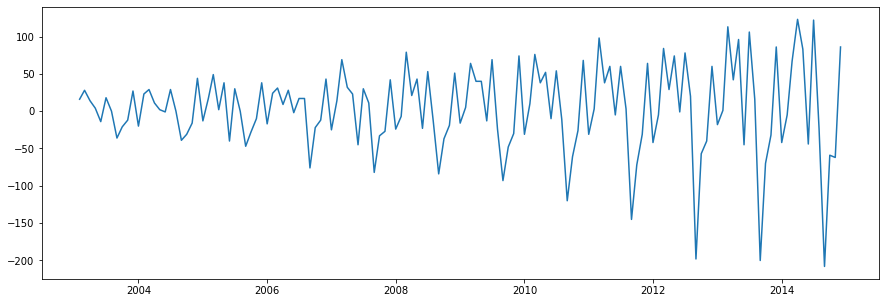

In [39]:
print(ts.head(5))
print()
print(ts.shift(1).head(5))
ts_diff = ts - ts.shift(1)  # ts.shift(1) returns the previous value in the series
print()
print(ts_diff.head(5))
plt.plot(ts_diff)

This appears to have reduced trend considerably. Lets verify using our plots:

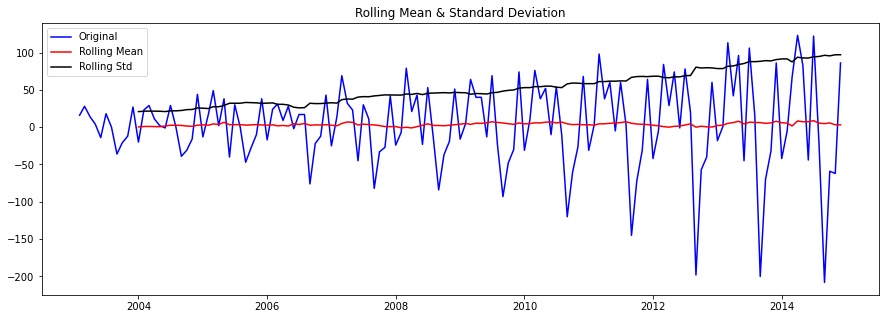

In [40]:
ts_diff.dropna(inplace=True)  # subtracting from previous values causes NaN-values at the beginning
test_stationarity(ts_diff)

We can see that the mean and std variations have small variations with time. We can also take second or third order differences which might get even better results in certain applications.  
  
Now that we are familiar with the concepts of moving average and differencing, we can apply them when configuring the ARIMA-algorithm

### Autoregressive Integrated Moving Average Model
  
A key role in time series analysis is played by processes whose properties, or some of them, do not vary with time. If we wish to make predictions, then clearly we must assume that something does not vary with time. In extrapolating deterministic functions it is common practice to assume that either the function itself or one of its derivatives is constant. The assumption of a constant first derivative leads to linear extrapolation as a means of prediction. In time series analysis our goal is to predict a series that typically is not deterministic but contains a random component. If this random component is stationary, in the sense of e.g. constant mean and constant variance, we can develop
powerful techniques to forecast its future values. ARIMA is one of those techniques. 

ARIMA is an acronym that stands for AutoRegressive Integrated Moving Average. It is a generalization of the simpler AutoRegressive Moving Average and adds the notion of integration.



The acronym ARIMA is descriptive, capturing the key aspects of the model itself. Briefly, they are:

- AR: **Autoregression**. A model that uses the dependent relationship between an observation and some number of lagged (previous) observations. It allows us to incorporate the effect of past values into our model. Intuitively, this would be similar to stating that it is likely to be warm tomorrow if it has been warm the past 3 days. 
- I: **Integrated**. The use of **differencing** of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.
- MA: **Moving Average**. A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.

Each of these components are explicitly specified in the model as a parameter. A standard notation used is **ARIMA(p,d,q)** where the parameters are substituted with integer values to quickly indicate the specific ARIMA model being used.

The parameters of the ARIMA model are defined as follows:

- p: The number of lag observations included in the model, also called the lag order. In case of the temperature predicton above p would be 3. 
- d: The number of times that the raw observations are differenced, also called the degree of differencing. In the Python example above d would be 1. 
- q: The order of moving average. In the Python example above the order of MA (and q) = 1. If you apply the subtracting of the moving average again on the result then q = 2 and so on.

In the ARIMA algorithm a linear regression model is constructed including the specified number and type of terms after the data has been prepared by a degree of differencing in order to make it stationary, i.e. to remove trend and seasonal structures that negatively affect the regression model.

A value of 0 can be used for a parameter, which indicates to not use that element of the model. This way, the ARIMA model can be configured to perform the function of an ARMA model, and even a simple AR, I, or MA model.

Adopting an ARIMA model for a time series assumes that the underlying process that generated the observations is an ARIMA process. This may seem obvious, but helps to motivate the need to confirm the assumptions of the model in the raw observations and in the residual errors of forecasts from the model.

Next, let’s take a look at how we can use the ARIMA model for the shampoo sales time series. 

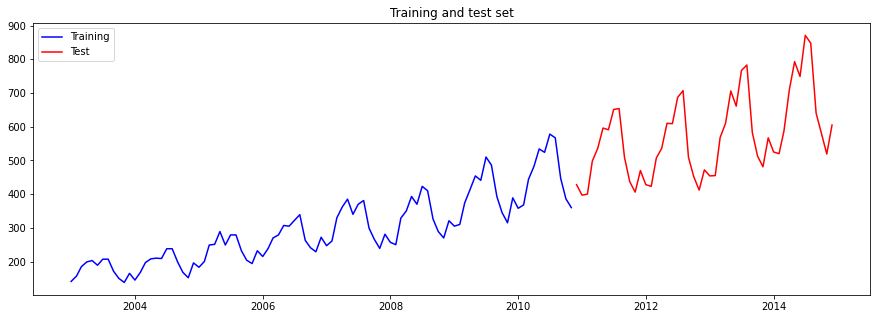

In [41]:
# split in training and test set

size = int(len(ts) * 0.66)
train, test = ts[0:size], ts[size:len(ts)]  # first 2/3 (= 2 years) = training set, remaining 1/3 (= 1 year)= test set

plt.plot(train, color='blue',label='Training')
plt.plot(test, color='red', label='Test')

plt.legend(loc='best')
plt.title('Training and test set')
plt.show()

### ARIMA with Python

The statsmodels library provides the capability to fit an ARIMA model.

An ARIMA model can be created using the statsmodels library as follows:

Define the model by calling `ARIMA()` and passing in the `p`, `d`, and `q` parameters.
The model is prepared on the training data by calling the `fit()` function.
Predictions can be made by calling the `forecast()` function and specifying the index of the time or times to be predicted.
Let’s start off with something simple. We will fit an ARIMA model to the entire Shampoo Sales dataset.

First, we can pass the parameters based on the visual exploration we did before. We pass parameters that make the process more or less stationary. The ARIMA(6,1,1) model then seems like a good guess. This sets the lag value to 6 (months) for autoregression, uses a difference order of 1 to make the time series stationary, and uses a moving average model degree of  1 too.



In [42]:
# first we define a function to calculate the mean absolute percentage error 
def MAPE(y_true, y_pred): 
    y_true = y_true.values
    y_pred = y_pred.values
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

Test MAPE: 9.3 %


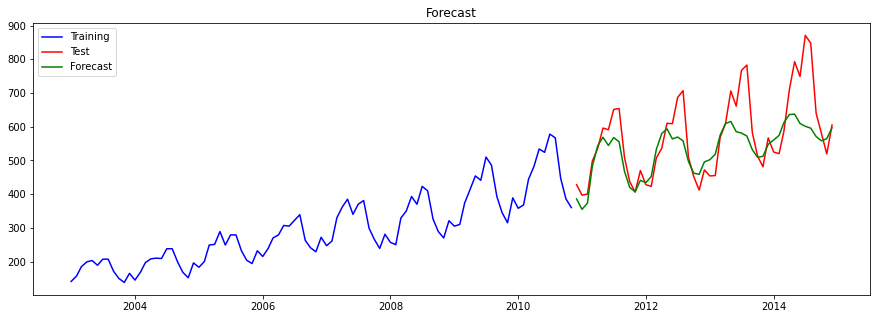

In [43]:
from statsmodels.tsa.arima_model import ARIMA
import math
model = ARIMA(train,order=(6,1,1))
model_fit = model.fit()
forecast = pd.DataFrame(model_fit.forecast(steps=len(test))[0],index=test.index)

error = MAPE(test, forecast)
print('Test MAPE: %.1f %%' %  error)
  
# Plot the train and test sets on the axis ax
plt.plot(train, color='blue',label='Training')
plt.plot(test, color='red', label='Test')
plt.plot(forecast, color='green', label='Forecast')
plt.legend(loc='best')
plt.title('Forecast')
plt.show()


Instead of using intuition or more elaborate mathematical methods for determing the ARIMA parameters, we can also use a brute force attack and try a range of parameter combinations to find the best model.

In [44]:
import itertools
import warnings
import sys

size_trainall = int(len(ts)*0.66)
print(size_trainall)
trainall, test = ts[0:size_trainall], ts[size_trainall:len(ts)]  

# further split training set in training and validation to avoid leaking of test data to the model
size_train = int(len(trainall)*0.66)
train,val = trainall[0:size_train], trainall[size_train:len(trainall)]

# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 7)

# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))
best_pdq = pdq
best_mape = 100000
warnings.filterwarnings("ignore") # specify to ignore warning messages
for param in pdq:
    print(param)

    try:   # some parametercombinations might lead to crash, so catch exceptions and continue
        model = ARIMA(train,order=param)
        model_fit = model.fit()
        forecast = pd.DataFrame(model_fit.forecast(steps=len(val))[0],index=val.index)
        mape = MAPE(val, forecast)
    
        if mape < best_mape:
            print('NEW BEST MAPE: %.1f %%' %  mape)
            best_mape = mape
            best_pdq = param
    except Exception as e:
        print(e)
        continue
 
print('Validation MAPE: %.1f %%' %  best_mape)
   



95
(0, 0, 0)
Cannot cast ufunc 'subtract' output from dtype('float64') to dtype('int64') with casting rule 'same_kind'
(0, 0, 1)
NEW BEST MAPE: 38.0 %
(0, 0, 2)
(0, 0, 3)
(0, 0, 4)
(0, 0, 5)
(0, 0, 6)
NEW BEST MAPE: 37.9 %
(0, 1, 0)
Cannot cast ufunc 'subtract' output from dtype('float64') to dtype('int64') with casting rule 'same_kind'
(0, 1, 1)
NEW BEST MAPE: 28.0 %
(0, 1, 2)
NEW BEST MAPE: 27.7 %
(0, 1, 3)
NEW BEST MAPE: 15.6 %
(0, 1, 4)
(0, 1, 5)
NEW BEST MAPE: 15.2 %
(0, 1, 6)
(0, 2, 0)
Cannot cast ufunc 'subtract' output from dtype('float64') to dtype('int64') with casting rule 'same_kind'
(0, 2, 1)
(0, 2, 2)
(0, 2, 3)
(0, 2, 4)
(0, 2, 5)
(0, 2, 6)
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
(0, 3, 0)
d > 2 is not supported
(0, 3, 1)
d > 2 is not supported
(0, 3, 2)
d > 2 is not supported
(0, 3, 3)
d > 2 is not supported
(0, 3, 4)
d > 2 is not supported
(0, 3, 5)
d 

No handles with labels found to put in legend.
Test MAPE: 7.0 %
(6, 1, 2)


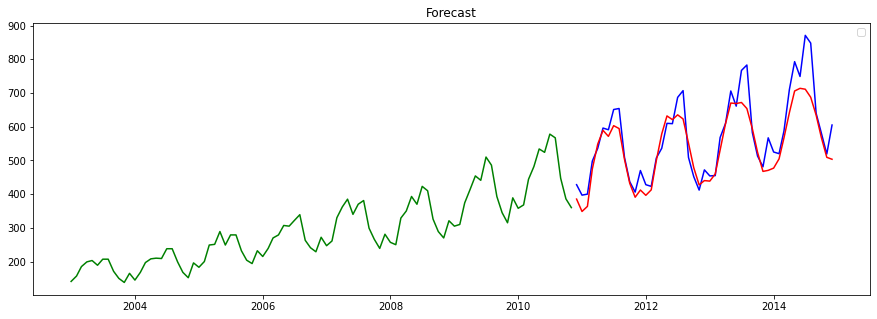

In [45]:
# We now rebuild the model for the complete training set with the above determined hyperparameters
model = ARIMA(trainall,order=best_pdq)
model_fit = model.fit()
forecast = pd.DataFrame(model_fit.forecast(steps=len(test))[0],index=test.index)

mape = MAPE(test, forecast)

print('Test MAPE: %.1f %%' %  best_mape)

print(best_pdq)
plt.plot(trainall, color='blue',label='Training')
plt.plot(test, color='red', label='Test')
plt.plot(forecast, color='green', label='Forecast')
plt.legend(loc='best')
plt.title('Forecast')
plt.show()